In [68]:
from accelerate import Accelerator
from datasets import Dataset, DatasetDict
import evaluate
from huggingface_hub import Repository, get_full_repo_name
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import classification_report
import torch
from torch.optim import AdamW
from torch.utils.data import DataLoader
from transformers import AutoModelForTokenClassification
from transformers import AutoTokenizer
from transformers import DataCollatorForTokenClassification
from transformers import get_scheduler
from transformers import TrainingArguments
from transformers import Trainer
from tqdm.auto import tqdm

## Helper functions and declarations

In [14]:
label_names = ['O', 'B-ART','I-ART','B-CON','I-CON','B-LOC','I-LOC',
        'B-MAT','I-MAT','B-PER','I-PER','B-SPE','I-SPE']
id2label = {i: l for i, l in enumerate(label_names)}
label2id = {l: i for i, l in id2label.items()}

model_name = "bert-finetuned-archeology"
base_model_checkpoint = "bert-base-cased"

In [15]:
def align_labels_with_tokens(labels, word_ids):
    new_labels = []
    current_word = None
    for word_id in word_ids:
        if word_id != current_word:
            # Start of a new word!
            current_word = word_id
            label = -100 if word_id is None else labels[word_id]
            new_labels.append(label)
        elif word_id is None:
            # Special token
            new_labels.append(-100)
        else:
            # Same word as previous token
            label = labels[word_id]
            # If the label is B-XXX we change it to I-XXX
            if label % 2 == 1:
                label += 1
            new_labels.append(label)

    return new_labels


def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(
        examples['tokens'], truncation=True, is_split_into_words=True
    )
    all_labels = examples['ner_tags']
    new_labels = []
    for i, labels in enumerate(all_labels):
        word_ids = tokenized_inputs.word_ids(i)
        new_labels.append(align_labels_with_tokens(labels, word_ids))
    
    tokenized_inputs['labels'] = new_labels
    return tokenized_inputs


def compute_metrics(eval_preds):
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)

    # Remove ignored index (special tokens) and convert to labels
    true_labels = [[label_names[l] for l in label if l != -100] for label in labels]
    true_predictions = [
        [label_names[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    all_metrics = metric.compute(predictions=true_predictions, references=true_labels)
    return {
        "precision": all_metrics["overall_precision"],
        "recall": all_metrics["overall_recall"],
        "f1": all_metrics["overall_f1"],
        "accuracy": all_metrics["overall_accuracy"],
    }


def parse(sentence):
    tokens, ner_tags = [], []
    for phrase in sentence:
            features = phrase.split(' ')
            tokens.append(features[0].strip())
            ner_tags.append(label2id[features[2].strip()])
    return {'tokens': tokens, 'ner_tags': ner_tags}


def postprocess(predictions, labels):
    predictions = predictions.detach().cpu().clone().numpy()
    labels = labels.detach().cpu().clone().numpy()

    # Remove ignored index (special tokens) and convert to labels
    true_labels = [[label_names[l] for l in label if l != -100] for label in labels]
    true_predictions = [
        [label_names[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    return true_labels, true_predictions

## Data Loading

In [16]:
raw_datasets = {}
for split in ('train', 'val', 'test'):
    raw_datasets[split] = {}
    with open(f'{split}.txt', 'r') as infile:
        raw_data = infile.read()
        lines = raw_data.split('\n')
        sentences = raw_data.split('\n\n')
        sentences = [parse(sentence.split('\n')) for sentence in sentences]
        for sentence in sentences:
            for k in sentence:
                if k not in raw_datasets[split].keys():
                    raw_datasets[split][k] = []
                raw_datasets[split][k].append(sentence[k])


datasets = {}
for split in raw_datasets.keys():
    datasets[split] = Dataset.from_dict(raw_datasets[split])
data = DatasetDict(datasets)

### Data statistics

#### NER label distribution

In [17]:
ner = data['train']['ner_tags']
ner += data['test']['ner_tags']
ner += data['val']['ner_tags']
ner = np.array([tag for taglist in ner for tag in taglist])

In [18]:
ner_df = pd.DataFrame(ner, columns=['ner_tag'])
ner_df['ner_label'] = ner_df['ner_tag'].map(id2label)
ner_df.loc[ner_df['ner_label'] != 'O','ner_label_grouped'] = \
    ner_df.loc[ner_df['ner_label'] != 'O','ner_label'].apply(
        lambda x: x.split('-')[1])
ner_df['ner_label_grouped'] = ner_df['ner_label_grouped'].fillna('O')
ner_df_counts = ner_df.groupby(
    ['ner_label_grouped', 'ner_label']
)['ner_label'].count().to_frame().drop('O')
ner_df_counts.columns = ['counts']

In [19]:
ner_distribution = ner_df.groupby(['ner_label_grouped', 'ner_label'])['ner_label'].count().to_frame()
ner_distribution.columns = ['counts']
ner_distribution = ner_distribution.reset_index()

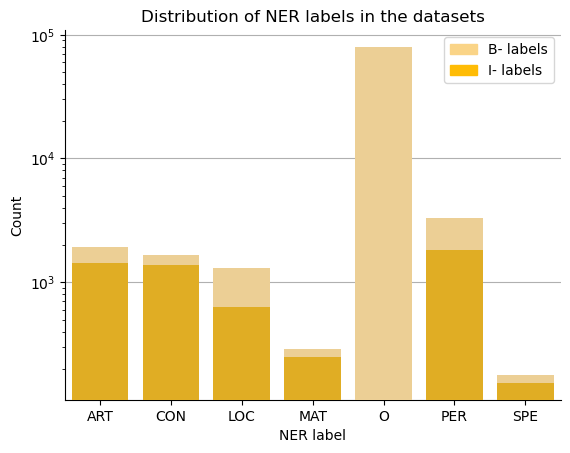

In [28]:
bottom_df = ner_distribution.loc[ner_distribution['ner_label'].str.startswith('B')]

fig, ax = plt.subplots()
ax.grid(axis='y', zorder=2)
sns.barplot(data=ner_distribution, x='ner_label_grouped', y='counts',
            estimator=sum, ax=ax, color='#fad487', errorbar=None, zorder=3)
sns.barplot(data=bottom_df, x='ner_label_grouped', y='counts', ax=ax,
            color='#ffbc05', zorder=3)
top_bar = mpatches.Patch(color='#fad487', label='B- labels')
bottom_bar = mpatches.Patch(color='#ffbc05', label='I- labels')
plt.legend(handles=[top_bar, bottom_bar])
ax.set_yscale('log')
sns.despine()
ax.set(title='Distribution of NER labels in the datasets',
       xlabel='NER label', ylabel='Count')
plt.show()

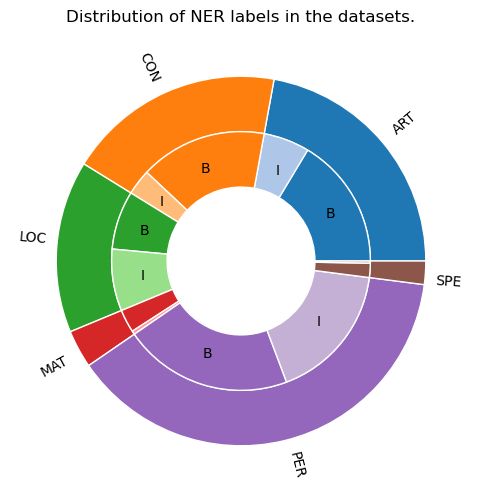

In [242]:
fig, ax = plt.subplots(figsize=(6, 6))
cmap = plt.colormaps["tab20"]
size=0.3
outer_colors = cmap(np.arange(6)*2)
inner_colors = cmap(np.arange(12))
textprops = {'color': 'k'}
startangle = 0

outer_labels = ner_df_counts.index.get_level_values(0).drop_duplicates()
wedges, texts = ax.pie(
    ner_df_counts.groupby(level=[0]).sum().values.flatten(),
    labels=outer_labels,
    radius=1, colors=outer_colors,
    wedgeprops=dict(width=size, edgecolor='w'),
    labeldistance=1.05,
    rotatelabels=True,
    textprops=textprops,
    startangle=startangle)

inner_labels = [i.split('-')[0] 
                for i in ner_df_counts.index.get_level_values(1).to_list()]

inner_labels[-2:] = [''] * 2
inner_labels[6:8] = [''] * 2
ax.pie(ner_df_counts.values.flatten(),
       labels=inner_labels,
       radius=1-size, colors=inner_colors,
       wedgeprops=dict(width=size, edgecolor='w'),
       labeldistance=0.75,
       textprops=textprops,
       startangle=startangle)

ax.set_title('Distribution of NER labels in the datasets.')
plt.show()

## Preprocessing

In [17]:
tokenizer = AutoTokenizer.from_pretrained(base_model_checkpoint)

data_tokenized = data.map(
    tokenize_and_align_labels,
    batched=True,
    remove_columns=data['train'].column_names)

Map:   0%|          | 0/1992 [00:00<?, ? examples/s]

Map:   0%|          | 0/850 [00:00<?, ? examples/s]

Map:   0%|          | 0/864 [00:00<?, ? examples/s]

## Training

### Training set-up

In [ ]:
data_collator = DataCollatorForTokenClassification(tokenizer)
metric = evaluate.load('seqeval')

model = AutoModelForTokenClassification.from_pretrained(
    base_model_checkpoint,
    id2label=id2label,
    label2id=label2id,
)

args = TrainingArguments(
    model_name,
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    num_train_epochs=3,
    weight_decay=0.01,
    push_to_hub=True,
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=data_tokenized["train"],
    eval_dataset=data_tokenized["val"],
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    processing_class=tokenizer,
)

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Training loop

In [34]:
trainer.train()
trainer.push_to_hub(commit_message="Training complete")

  0%|          | 0/747 [00:00<?, ?it/s]

{'eval_loss': 0.21270084381103516, 'eval_precision': 0.499194847020934, 'eval_recall': 0.6378600823045267, 'eval_f1': 0.5600722673893406, 'eval_accuracy': 0.9467969124765601, 'eval_runtime': 11.5379, 'eval_samples_per_second': 73.67, 'eval_steps_per_second': 9.274, 'epoch': 1.0}


  0%|          | 0/107 [00:00<?, ?it/s]

{'eval_loss': 0.2322877198457718, 'eval_precision': 0.5253968253968254, 'eval_recall': 0.6810699588477366, 'eval_f1': 0.5931899641577061, 'eval_accuracy': 0.9476690942392395, 'eval_runtime': 12.3934, 'eval_samples_per_second': 68.585, 'eval_steps_per_second': 8.634, 'epoch': 2.0}
{'loss': 0.0737, 'grad_norm': 0.9115849137306213, 'learning_rate': 6.6131191432396255e-06, 'epoch': 2.01}


  0%|          | 0/107 [00:00<?, ?it/s]

{'eval_loss': 0.2524833381175995, 'eval_precision': 0.5037537537537538, 'eval_recall': 0.6903292181069959, 'eval_f1': 0.5824652777777778, 'eval_accuracy': 0.9453142034800053, 'eval_runtime': 11.5912, 'eval_samples_per_second': 73.331, 'eval_steps_per_second': 9.231, 'epoch': 3.0}
{'train_runtime': 626.9456, 'train_samples_per_second': 9.532, 'train_steps_per_second': 1.191, 'train_loss': 0.06035551584389315, 'epoch': 3.0}


events.out.tfevents.1730815554.Jans-MacBook-Pro-2.local.3581.0:   0%|          | 0.00/12.9k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/janzuromski/bert-finetuned-archeology/commit/1656eb825c37e4fc19604b11d726843bb4799f6c', commit_message='Training complete', commit_description='', oid='1656eb825c37e4fc19604b11d726843bb4799f6c', pr_url=None, repo_url=RepoUrl('https://huggingface.co/janzuromski/bert-finetuned-archeology', endpoint='https://huggingface.co', repo_type='model', repo_id='janzuromski/bert-finetuned-archeology'), pr_revision=None, pr_num=None)

## Custom model model fine-tuning

In [24]:
model_checkpoint = 'bert-base-cased'
data_collator = DataCollatorForTokenClassification(tokenizer)
metric = evaluate.load('seqeval')
model = AutoModelForTokenClassification.from_pretrained(
    model_checkpoint, id2label=id2label, label2id=label2id
)
optimizer = AdamW(model.parameters(), lr=2e-5)

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [25]:
train_dataloader = DataLoader(
    data_tokenized['train'],
    shuffle=True,
    collate_fn=data_collator,
    batch_size=8,
)

eval_dataloader = DataLoader(
    data_tokenized['val'],
    collate_fn=data_collator,
    batch_size=8,
)

In [26]:
accelerator = Accelerator()
model, optimizer, train_dataloader, eval_dataloader = accelerator.prepare(
    model, optimizer, train_dataloader, eval_dataloader
)

In [27]:
num_train_epochs = 3
num_update_steps_per_epoch = len(train_dataloader)
num_training_steps = num_train_epochs * num_update_steps_per_epoch

lr_scheduler = get_scheduler(
    'linear',
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps
)

In [ ]:
model_name = "bert-finetuned-archeology-custom"
output_dir = model_name
repo_name = get_full_repo_name(model_name)
repo = Repository(output_dir, clone_from=repo_name)
repo_name

In [ ]:
progress_bar = tqdm(range(num_training_steps))
all_results = {}

for epoch in range(num_train_epochs):
    model.train()
    for batch in train_dataloader:
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

    model.eval()
    for batch in eval_dataloader:
        with torch.no_grad():
            outputs = model(**batch)
        
        predictions = outputs.logits.argmax(dim=-1)
        labels = batch['labels']
        predictions_padded = accelerator.pad_across_processes(predictions, 
                                                              dim=1, 
                                                              pad_index=-100)
        labels_padded = accelerator.pad_across_processes(labels, 
                                                         dim=1, 
                                                         pad_index=-100)
        predictions_gathered = accelerator.gather(predictions_padded)
        labels_gathered = accelerator.gather(labels_padded)

        true_predictions, true_labels = postprocess(predictions_gathered,
                                                    labels_gathered)

        metric.add_batch(predictions=true_predictions, references=true_labels)
    all_results[epoch] = metric.compute()
    print(
        f"epoch {epoch}:",
        {
            key: all_results[epoch][f"overall_{key}"]
            for key in ["precision", "recall", "f1", "accuracy"]
        },
    )

    accelerator.wait_for_everyone()
    unwrapped_model = accelerator.unwrap_model(model)
    unwrapped_model.save_pretrained(output_dir, save_function=accelerator.save)
    if accelerator.is_main_process:
        tokenizer.save_pretrained(output_dir)
        repo.push_to_hub(
            commit_message=f"Training in progress epoch {epoch}", blocking=False)





  0%|          | 0/747 [00:00<?, ?it/s]

epoch 0: {'precision': 0.6460905349794238, 
          'recall': 0.4422535211267606, 
          'f1': 0.5250836120401338, 
          'accuracy': 0.9359382495312023}

epoch 1: {'precision': 0.6995884773662552, 
          'recall': 0.45729657027572296, 
          'f1': 0.5530703538023588, 
          'accuracy': 0.937639003968427}

epoch 2: {'precision': 0.6851851851851852, 
          'recall': 0.4915129151291513, 
          'f1': 0.5724108293940697, 
          'accuracy': 0.9438314944834504}


## Evaluation

### Initialization

In [ ]:
# In case model was trained in another notebook execution
model_name = 'bert-finetuned-archeology-custom'
model = AutoModelForTokenClassification.from_pretrained(f'janzuromski/{model_name}')
tokenizer = AutoTokenizer.from_pretrained(base_model_checkpoint)
data_collator = DataCollatorForTokenClassification(tokenizer)
metric = evaluate.load('seqeval')

test_dataloader = DataLoader(
    data_tokenized['test'],
    collate_fn=data_collator,
    batch_size=8
)

### Inference

In [ ]:
progress_bar = tqdm(range(len(test_dataloader)))
model.eval()
model.to('mps')
all_preds, all_labels = [], []
for batch in test_dataloader:
    batch.to('mps')
    with torch.no_grad():
        outputs = model(**batch)
    
    predictions = outputs.logits.argmax(dim=-1)
    labels = batch['labels']
    true_predictions, true_labels = postprocess(predictions, labels)
    all_preds += true_predictions
    all_labels += true_labels
    progress_bar.update(1)

  0%|          | 0/108 [00:00<?, ?it/s]

In [69]:
preds_flat = [l for e in all_preds for l in e]
labels_flat = [l for e in all_labels for l in e]
report = classification_report(labels_flat, preds_flat, zero_division=0.0,
                               output_dict=True)